<h1>On va utiliser le modèle entrainé </h1>

<h2>Module nécéssaire</h2>

In [23]:
from keras.models import load_model
import numpy as np
import os
import tensorflow  as tf

<h2>On a aussi besoin du loader</h2>

In [24]:
def load_img(img_dir,img_list):
    images=[]
    for i, image_name in enumerate(img_list):
        if(image_name.split('.')[1]== 'npy'):
            image = np.load(img_dir+image_name)
            images.append(image)
    images = np.array(images)
    return(images)

def imageLoader(img_dir, img_list, mask_dir, mask_list, batch_size):
    L=len(img_list)
    
    
    #Keras à besoin d'un générateur infini
    while True:

        batch_start=0
        batch_end = batch_size

        while batch_start < L:
            limit= min(batch_end,L)

            X=load_img(img_dir, img_list[batch_start:limit])
            Y=load_img(mask_dir, mask_list[batch_start:limit])

            yield(X,Y)# documentation pour comprendre ce que le yield fait 

            batch_start += batch_size
            batch_end += batch_size

<h2> On définit les répertoires </h2>

In [25]:
#Define the image generators for training and validation

train_img_dir = "/Users/bimlaboratoire/python/stage_mzoughebi/notebook/PYTHON/archive/BraTS2020_TrainingData/input_data_128_2channels/train/images/"
train_mask_dir = "/Users/bimlaboratoire/python/stage_mzoughebi/notebook/PYTHON/archive/BraTS2020_TrainingData/input_data_128_2channels/train/masks/"

val_img_dir = "/Users/bimlaboratoire/python/stage_mzoughebi/notebook/PYTHON/archive/BraTS2020_TrainingData/input_data_128_2channels/val/images/"
val_mask_dir = "/Users/bimlaboratoire/python/stage_mzoughebi/notebook/PYTHON/archive/BraTS2020_TrainingData/input_data_128_2channels/val/masks/"

train_img_list=os.listdir(train_img_dir)
train_mask_list = os.listdir(train_mask_dir)

val_img_list=os.listdir(val_img_dir)
val_mask_list = os.listdir(val_mask_dir)

### definit les couleurs de masque

In [26]:
import matplotlib.colors as mcolors

# Créez un dictionnaire qui associe chaque classe à une couleur spécifique
legende_classe = {
    0: 'gray',   # Classe 0: Volume non labelisé - Gris
    1: 'red',     # Classe 1: Nécrose tumorale et corps non révelé (NCR/NET) - Rouge
    2: 'yellow',   # Classe 2: Oedème péritumoral (ED) - Jaune
    3: 'orange'       # Classe 3: Corps de la tumeur révelé par l'agent de contraste - Orange
}

### On affiche un patient avant et après traitement 


[0 1 2 4]
[0 1 2 3]


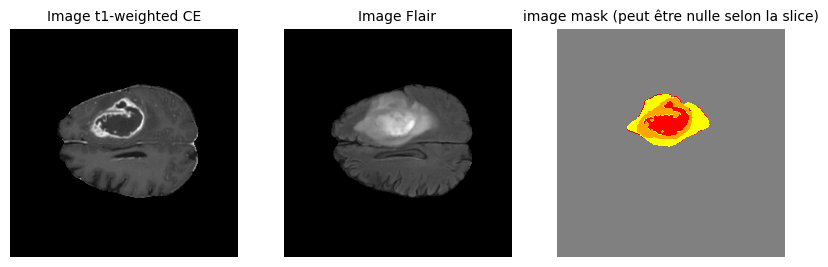

97


In [27]:
import matplotlib.pyplot as plt
import nibabel as nib
##### DEFINITION DU PATH ######
TRAIN_DATASET_PATH = '/Users/bimlaboratoire/python/stage_mzoughebi/notebook/PYTHON/archive/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/'
###### Chargement d'une image TEST FLAIR size (240 240 155)######
image_flair_pre_traitement= nib.load(TRAIN_DATASET_PATH+'BraTS20_Training_355/BraTS20_Training_355_flair.nii').get_fdata()
####### Dans le cas d'un modèle à deux canal on applique cela que sur T1-weighted contrasté en plus ######
image_t1ce_pre_traitement= nib.load(TRAIN_DATASET_PATH+'BraTS20_Training_355/BraTS20_Training_355_t1ce.nii').get_fdata()
####### Dans le cas d'un modèle à deux canal on applique cela que sur T1-weighted contrasté en plus ######
mask_pre_traitement= nib.load(TRAIN_DATASET_PATH+'BraTS20_Training_355/BraTS20_Training_355_seg.nii').get_fdata()

#### On choisit une slice aléatoirement
import random as rd
n_slice = 97

######## On charge le Masque #########

mask_pre_traitement=mask_pre_traitement.astype(np.uint8)
print(np.unique(mask_pre_traitement))
mask_pre_traitement[mask_pre_traitement==4] = 3 ##LE LABEL 4 EST CHANGE EN 3
print(np.unique(mask_pre_traitement))


# Création d'une figure avec 1 ligne et 3 colonnes
fig, axs = plt.subplots(1, 3, figsize=(10, 5))


# Affichage de T1-WEIGHTED
axs[0].imshow(image_t1ce_pre_traitement[:,:,n_slice], cmap='gray')
axs[0].axis('off')
axs[0].set_title("Image t1-weighted CE", fontsize=10)

# Affichage de FLAIR
axs[1].imshow(image_flair_pre_traitement[:,:,n_slice], cmap='gray')
axs[1].axis('off')
axs[1].set_title("Image Flair", fontsize=10)



#Affichage du MASQUE
axs[2].imshow(mask_pre_traitement[:, :, n_slice], cmap=mcolors.ListedColormap(list(class_colors.values())))
axs[2].axis('off')
axs[2].set_title("image mask (peut être nulle selon la slice)", fontsize=10)


# Affichage du tableau avec les deux cellules
plt.show()
print(n_slice)

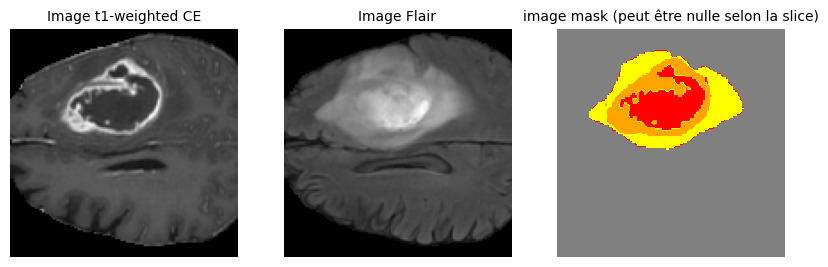

97


In [28]:
# Création d'une figure avec 1 ligne et 3 colonnes
fig, axs = plt.subplots(1, 3, figsize=(10, 5))


# Affichage de T1-WEIGHTED
axs[0].imshow(image_t1ce_pre_traitement[56:184,56:184,n_slice], cmap='gray')
axs[0].axis('off')
axs[0].set_title("Image t1-weighted CE", fontsize=10)

# Affichage de FLAIR
axs[1].imshow(image_flair_pre_traitement[56:184,56:184,n_slice], cmap='gray')
axs[1].axis('off')
axs[1].set_title("Image Flair", fontsize=10)



#Affichage du MASQUE
axs[2].imshow(mask_pre_traitement[56:184,56:184, n_slice], cmap=mcolors.ListedColormap(list(class_colors.values())))
axs[2].axis('off')
axs[2].set_title("image mask (peut être nulle selon la slice)", fontsize=10)


# Affichage du tableau avec les deux cellules
plt.show()
print(n_slice)

(128, 128, 128, 4)


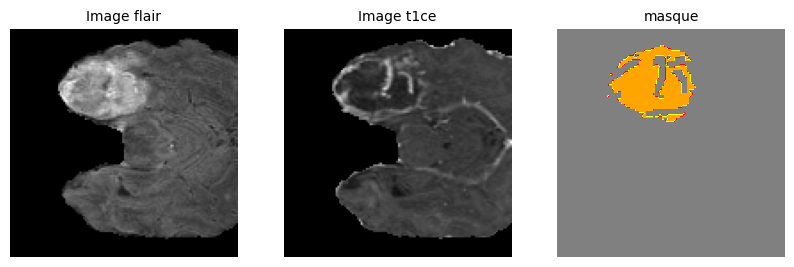

33


In [29]:

########## On vérifie que l'on arrive à les réouvrir à l'identique ######################
combined_x=np.load('/Users/bimlaboratoire/python/stage_mzoughebi/notebook/PYTHON/archive/BraTS2020_TrainingData/input_data_128_2channels/val/images/patient_63.npy')
masque=np.load('/Users/bimlaboratoire/python/stage_mzoughebi/notebook/PYTHON/archive/BraTS2020_TrainingData/input_data_128_2channels/val/masks/patient_63.npy')

# On est obligé d'afficher une autre slice pour eviter un index out of range
n_slice = 33
#Nécessaireement cela ne sera plus la meme slice exactement

# Création d'une figure avec 2 ligne et 3 colonnes
fig, axs = plt.subplots(1, 3, figsize=(10, 5))

# Affichage de l'image flair
axs[0].imshow(combined_x[:,:,n_slice, 0], cmap='gray')
axs[0].axis('off')
axs[0].set_title("Image flair" ,fontsize=10)

# Affichage de l'image T1-WEIGHTED
axs[1].imshow(combined_x[:,:,n_slice, 1], cmap='gray')
axs[1].axis('off')
axs[1].set_title("Image t1ce", fontsize=10)


# Affichage du masque
print(masque.shape)
axs[2].imshow(masque[:, :, n_slice,1], cmap=mcolors.ListedColormap(list(class_colors.values())))
axs[2].axis('off')
axs[2].set_title("masque", fontsize=10)

# Affichage du tableau avec les deux cellules
plt.show()
print(n_slice)


<h3>Validation</h3>

1/1 [==============================] - 1s 1s/step


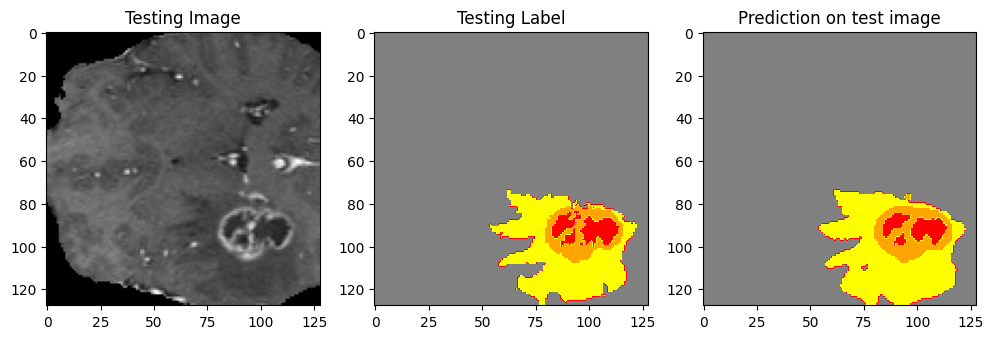

In [30]:
#############################################
#Predict on a few test images, one at a time
#Try images: 
# Charger le modèle sans compilation
my_model = tf.keras.models.load_model('brats_3dvf.hdf5', compile=False)
img_num = 82

test_img = np.load(val_img_dir + "patient_"+str(img_num)+".npy")
test_mask = np.load(val_mask_dir + "patient_"+str(img_num)+".npy")
test_mask_argmax=np.argmax(test_mask, axis=3)

test_img_input = np.expand_dims(test_img, axis=0)
test_prediction = my_model.predict(test_img_input)
test_prediction_argmax=np.argmax(test_prediction, axis=4)[0,:,:,:]

# print(test_prediction_argmax.shape)
# print(test_mask_argmax.shape)
# print(np.unique(test_prediction_argmax))

#Plot individual slices from test predictions for verification
from matplotlib import pyplot as plt
import random

#n_slice=random.randint(0, test_prediction_argmax.shape[2])
n_slice = 53
plt.figure(figsize=(12, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img[:,:,n_slice,1], cmap='gray')
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(test_mask_argmax[:,:,n_slice], cmap=mcolors.ListedColormap(list(class_colors.values())))
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(test_prediction_argmax[:,:, n_slice],cmap=mcolors.ListedColormap(list(class_colors.values())))
plt.show()

############################################################

## On va recharger le patient de test 

(128, 128, 128, 2)


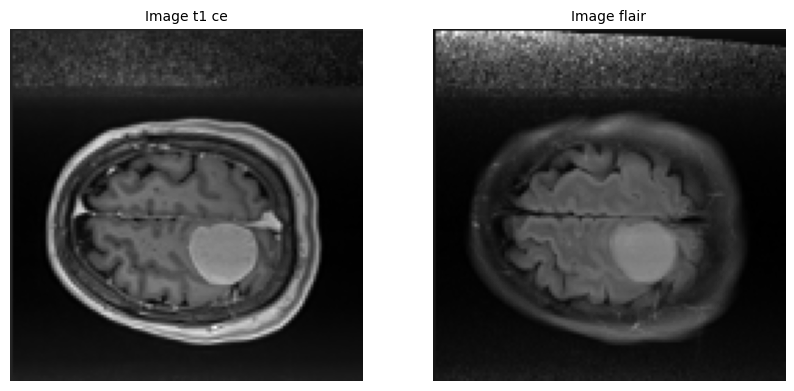

In [31]:
test_img = np.load("/Users/bimlaboratoire/python/stage_mzoughebi/notebook/PYTHON/DataBase_IA/input_128/test.npy")
test_img_brats = np.load("/Users/bimlaboratoire/python/stage_mzoughebi/notebook/PYTHON/DataBase_IA/input_128/test_brats.npy")
print(test_img.shape)
slice=[20]

for n_slice in slice:
    # Création d'une figure avec 1 ligne et 2 colonnes
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))

    # Affichage de l'image t1
    axs[0].imshow(test_img[n_slice,:,:,1], cmap='gray')
    axs[0].axis('off')
    axs[0].set_title("Image t1 ce" ,fontsize=10)

    # Affichage de l'image flair
    
    axs[1].imshow(test_img[n_slice,:,:,0], cmap='gray')
    axs[1].axis('off')
    axs[1].set_title("Image flair", fontsize=10)


    # Affichage du tableau avec les deux cellules
    plt.show()

## Test sur un patient de BraTS

1/1 [==============================] - 1s 993ms/step
(1, 128, 128, 128, 4)
(128, 128, 128)


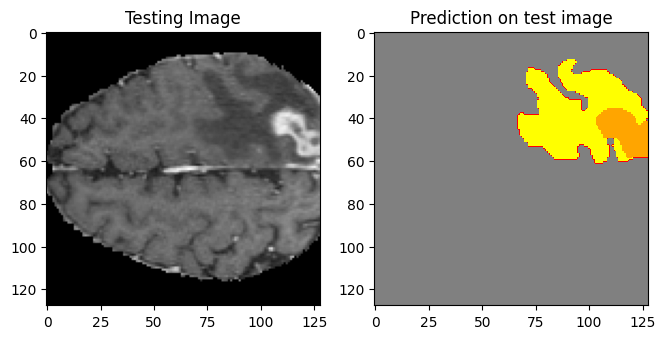

In [32]:
#############################################
#Predict on a few test images, one at a time
#Try images: 
# Charger le modèle sans compilation
my_model = tf.keras.models.load_model('brats_3d.hdf5', compile=False)
img_num = 99

test_img_input = np.expand_dims(test_img_brats, axis=0)
test_prediction = my_model.predict(test_img_input)
print (test_prediction.shape)
test_prediction_argmax=np.argmax(test_prediction, axis=4)[0,:,:,:]
print (test_prediction_argmax.shape)
# print(test_prediction_argmax.shape)
# print(test_mask_argmax.shape)
# print(np.unique(test_prediction_argmax))

#Plot individual slices from test predictions for verification
from matplotlib import pyplot as plt
import random

#n_slice=random.randint(0, test_prediction_argmax.shape[2])

plt.figure(figsize=(12, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img_brats[:,:,99, 1], cmap='gray')
plt.subplot(232)
plt.title('Prediction on test image')
plt.imshow(test_prediction_argmax[:,:,img_num], cmap=mcolors.ListedColormap(list(class_colors.values())))
plt.show()

############################################################

## Test sur un des patients du chul

1/1 [==============================] - 1s 968ms/step
(1, 128, 128, 128, 4)
(128, 128, 128)


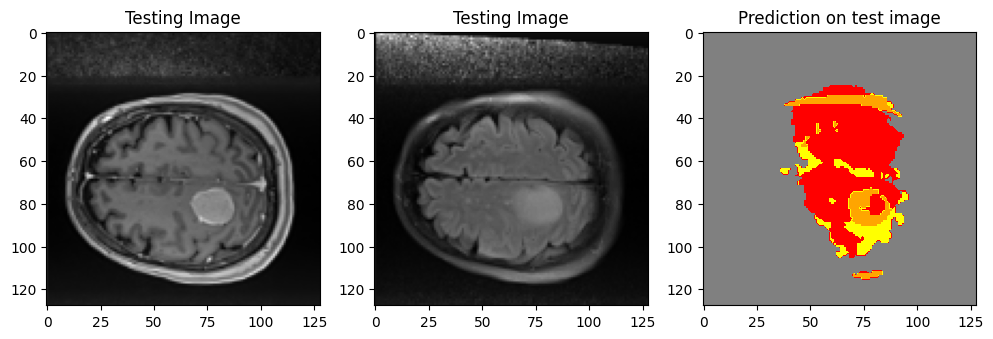

In [33]:
#############################################
#Predict on a few test images, one at a time
#Try images: 
# Charger le modèle sans compilation
my_model = tf.keras.models.load_model('brats_3d.hdf5', compile=False)
img_num = 30
test_img_input = np.expand_dims(test_img, axis=0)
test_prediction = my_model.predict(test_img_input)
print (test_prediction.shape)
test_prediction_argmax=np.argmax(test_prediction, axis=4)[0,:,:,:]
print (test_prediction_argmax.shape)
# print(test_prediction_argmax.shape)
# print(test_mask_argmax.shape)
# print(np.unique(test_prediction_argmax))

#Plot individual slices from test predictions for verification
from matplotlib import pyplot as plt
import random

#n_slice=random.randint(0, test_prediction_argmax.shape[2])

plt.figure(figsize=(12, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img[img_num,:,:,1], cmap='gray')
plt.subplot(232)
plt.title('Testing Image')
plt.imshow(test_img[img_num,:,:,0], cmap='gray')
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(test_prediction_argmax[img_num,:,:], cmap=mcolors.ListedColormap(list(class_colors.values())))
plt.show()

############################################################